<a href="https://colab.research.google.com/github/RoyZhaoGA/DroughtForecastAI/blob/main/Spatial_temporal_graph_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=680104c52571e302b031b9ec7fd5a880ef98483512d8e5b240f1e189dd96642d
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Gen RAM Free: 87.6 GB  |     Proc size: 98.3 MB
GPU RAM Free: 40511MB | Used: 2MB | Util   0% | Total     40960MB


In [3]:
!pip install lightning torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 66.2 MB/s eta 0:00:00


In [ ]:
!pip install torch --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
CHECKPOINT_PATH

'saved_models/GNNs/'

In [4]:
# Standard libraries
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import lightning as L

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from lightning.pytorch.callbacks import ModelCheckpoint
from torch import Tensor

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/drive/MyDrive/DroughtCastAI/Dataset/GNNs"

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Import Graph

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pickle
Graph = pickle.load(open('/content/drive/MyDrive/DroughtCastAI/Dataset/Spatial_temporal_grpah.pickle', 'rb'))

In [36]:
Graph

In [9]:
len(Graph.nodes)

83580

In [10]:
Graph.nodes[36986]

{'row_index': 36986,
 'Month': 202211,
 'Lat': -33.238,
 'Lon': 18.865,
 'temperature_2m': 292.636,
 'temperature_2m_min': 283.228,
 'temperature_2m_max': 308.313,
 'dewpoint_temperature_2m': 282.864,
 'total_precipitation_sum': 0.0166007,
 'total_precipitation_min': 0.0,
 'total_precipitation_max': 0.00481202,
 'u_component_of_wind_10m': 1.00666,
 'v_component_of_wind_10m': 1.20606,
 'surface_net_solar_radiation_sum': 681535000.0,
 'total_evaporation_sum': -0.0276847,
 'soil_moisture_am': 0.112796,
 'soil_moisture_pm': 0.110107,
 'NDVI': 3640.99,
 'EVI': 2116.21,
 'next_month_tempreature': 293.258,
 'next_month_precipitation': 3.743e-06,
 'year': 2022,
 'month2': 11,
 'spei01': -0.960185}

In [28]:
len(Graph.nodes[36986])

24

In [9]:
#graph subset only
import networkx as nx

monthslist = [202211, 202212, 202301, 202302, 202303, 202304, 202305, 202306, 202307, 202308]

subset_graph = nx.Graph()
for node, data in Graph.nodes(data=True):
    if data.get('Month') in monthslist:
        subset_graph.add_node(node, **data)

for u, v in Graph.edges():
    if u in subset_graph.nodes() and v in subset_graph.nodes():
        subset_graph.add_edge(u, v)

len(subset_graph.nodes)
Graph = subset_graph

In [10]:
subset_graph.nodes[24697]

{'row_index': 24697,
 'Month': 202308,
 'Lat': 36.831,
 'Lon': 9.881,
 'temperature_2m': 300.416,
 'temperature_2m_min': 290.927,
 'temperature_2m_max': 316.689,
 'dewpoint_temperature_2m': 289.995,
 'total_precipitation_sum': 0.00421884,
 'total_precipitation_min': 0.0,
 'total_precipitation_max': 0.00182504,
 'u_component_of_wind_10m': 0.486217,
 'v_component_of_wind_10m': -0.879292,
 'surface_net_solar_radiation_sum': 595211000.0,
 'total_evaporation_sum': -0.0155104,
 'soil_moisture_am': 0.072868,
 'soil_moisture_pm': 0.0555854,
 'NDVI': 2068.83,
 'EVI': 1417.39,
 'next_month_tempreature': 299.922,
 'next_month_precipitation': 1.54105e-05,
 'year': 2023,
 'month2': 8,
 'spei01': -1.05509}

In [ ]:
subset_graph.edges()

EdgeView([(36986, 37086), (36986, 40586), (36986, 40686), (36986, 36987), (36986, 36988), (40586, 37086), (40586, 44286), (40586, 44386), (40586, 40686), (40586, 40587), (40586, 40588), (44286, 48186), (44286, 44386), (44286, 48086), (44286, 40686), (44286, 44287), (44286, 44288), (48086, 48186), (48086, 44386), (48086, 51886), (48086, 51786), (48086, 48087), (48086, 48088), (51786, 48186), (51786, 55586), (51786, 55486), (51786, 51886), (51786, 51787), (51786, 51788), (55486, 55586), (55486, 59186), (55486, 51886), (55486, 55487), (55486, 55488), (37086, 37186), (37086, 33486), (37086, 40686), (37086, 40786), (37086, 37087), (37086, 37088), (40686, 37186), (40686, 44386), (40686, 40786), (40686, 44486), (40686, 40687), (40686, 40688), (44386, 48186), (44386, 40786), (44386, 48286), (44386, 44486), (44386, 44387), (44386, 44388), (48186, 48286), (48186, 44486), (48186, 51886), (48186, 51986), (48186, 48187), (48186, 48188), (51886, 48286), (51886, 55586), (51886, 51986), (51886, 55686)

In [ ]:
subset_graph.nodes

NodeView((36986, 40586, 44286, 48086, 51786, 55486, 37086, 40686, 44386, 48186, 51886, 55586, 59186, 33486, 37186, 40786, 44486, 48286, 51986, 55686, 59286, 62786, 30086, 33586, 37286, 40886, 44586, 48386, 52086, 55786, 59386, 62886, 30186, 33686, 37386, 40986, 44686, 48486, 52186, 55886, 59486, 62986, 66285, 30286, 33786, 37486, 41086, 44786, 48586, 52286, 55986, 59586, 63086, 66385, 69585, 79471, 80571, 81571, 30386, 33886, 37586, 41186, 44886, 48686, 52386, 56086, 59686, 63186, 66485, 69685, 79571, 80671, 81671, 27087, 30486, 33986, 37686, 41286, 44986, 48786, 52486, 56186, 59786, 63286, 66585, 69784, 79671, 80771, 81771, 27187, 30586, 34086, 37786, 41386, 45086, 48886, 52586, 56286, 59886, 63386, 66685, 69883, 72683, 79771, 80871, 81871, 82670, 24788, 27287, 30686, 34186, 37886, 41486, 45186, 48986, 52686, 56386, 59986, 63486, 66785, 69983, 72783, 75079, 79871, 80971, 81971, 82770, 27387, 30786, 34286, 37986, 41586, 45286, 49086, 52786, 56486, 60086, 63586, 66885, 70083, 72883, 751

In [29]:
len(subset_graph.edges)

45292

**Convert Graph into pytorch geometric dataset**

In [7]:
#EDGE INDEX FOR FULL DATASET
# Extract edge list
edge_list = list(Graph.edges())

# Convert edge list to a 2D tensor
edge_index = torch.tensor(edge_list, dtype=torch.long)
edge_index = edge_index.t().contiguous()

# Ensure the tensor shape is [2, num_edges]
edge_index = edge_index.view(2, -1)

#EDGE INDEX FOR SMALL DATASET
# # Extract edge list
# original_edge_list = list(Graph.edges())
# edge_list = []

# for i, node in enumerate(Graph.nodes()):
#   for j, node2 in enumerate(Graph.nodes()):
#     if (node, node2) in Graph.edges():
#       edge_list.append((i,j))

# # Convert edge list to a 2D tensor
# edge_index = torch.tensor(edge_list, dtype=torch.long)
# edge_index = edge_index.t().contiguous()

# # Ensure the tensor shape is [2, num_edges]
# edge_index = edge_index.view(2, -1)

spei01_features = [Graph.nodes[node]['spei01'] for node in Graph.nodes()]

# Convert to a tensor
y = torch.tensor(spei01_features, dtype=torch.float)

feature_names = ['Month', 'Lat', 'Lon', 'temperature_2m', 'temperature_2m_min',
                 'temperature_2m_max', 'dewpoint_temperature_2m', 'total_precipitation_sum',
                 'total_precipitation_min', 'total_precipitation_max', 'u_component_of_wind_10m',
                 'v_component_of_wind_10m', 'surface_net_solar_radiation_sum', 'total_evaporation_sum',
                 'soil_moisture_am', 'soil_moisture_pm', 'NDVI', 'EVI', 'next_month_tempreature',
                 'next_month_precipitation', 'year', 'month2']

# Extract the features for each node
node_features = []
for node in Graph.nodes():
    node_feature_values = [Graph.nodes[node].get(feature, 0) for feature in feature_names]  # Defaulting missing values to 0
    node_features.append(node_feature_values)

# Convert to a PyTorch tensor
x = torch.tensor(node_features, dtype=torch.float)

# train_months = [202211, 202212, 202301, 202302, 202303, 202304, 202305, 202306]
# val_months = [202307]
# test_months = [202308]

train_months = [201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512,
201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608,
201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704,
201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712,
201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808,
201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904,
201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912,
202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008,
202009, 202010, 202011, 202012, 202101, 202102]
val_months = [202103, 202104, 202105, 202106, 202107, 202108, 202109,
202110, 202111, 202112, 202201, 202202, 202203, 202204, 202205]
test_months = [202206, 202207, 202208, 202209, 202210, 202211, 202212, 202301, 202302, 202303, 202304, 202305, 202306, 202307, 202308]

train_mask_list = []

for node in Graph.nodes():
    is_in_train_months = Graph.nodes[node]['Month'] in train_months
    train_mask_list.append(is_in_train_months)

train_mask = torch.tensor(train_mask_list, dtype=torch.bool)

val_mask_list = []

for node in Graph.nodes():
    is_in_val_months = Graph.nodes[node]['Month'] in val_months

    val_mask_list.append(is_in_val_months)

val_mask = torch.tensor(val_mask_list, dtype=torch.bool)

test_mask_list = []

for node in Graph.nodes():
    is_in_test_months = Graph.nodes[node]['Month'] in test_months

    test_mask_list.append(is_in_test_months)

test_mask = torch.tensor(test_mask_list, dtype=torch.bool)

graph_data = torch_geometric.data.Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

In [12]:
edge_index

tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]])

In [32]:
y

tensor([-0.6462, -0.0601, -0.3957,  ..., -2.6574, -1.4963, -1.0551])

In [33]:
x

tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]])

In [38]:
len(train_months)

70

In [39]:
len(val_months)

15

In [40]:
len(test_months)

15

In [42]:
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [41]:
torch.sum(train_mask).item()

58520

In [ ]:
val_mask

tensor([False, False, False,  ..., False, False, False])

In [15]:
torch.sum(val_mask).item()

12540

In [13]:
test_mask

tensor([False, False, False,  ...,  True,  True,  True])

In [14]:
torch.sum(test_mask).item()

12520

In [45]:
graph_data

Data(x=[83580, 22], edge_index=[2, 475295], y=[83580], train_mask=[83580], val_mask=[83580], test_mask=[83580])

In [8]:
from torch.utils.data import Dataset, DataLoader

In [9]:
class GraphDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.num_node_features = data.x.size(1)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return graph_data

In [10]:
graph_dataset = GraphDataset(graph_data)

In [49]:
graph_dataset.data

Data(x=[83580, 22], edge_index=[2, 475295], y=[83580], train_mask=[83580], val_mask=[83580], test_mask=[83580])

In [19]:
graph_dataset.__len__()

1

In [20]:
graph_dataset.__getitem__(0)

Data(x=[83580, 22], edge_index=[2, 475295], y=[83580], train_mask=[83580], val_mask=[83580], test_mask=[83580])

In [21]:
graph_dataset.num_node_features

22

## Graph Neural Networks

In [11]:
gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}

In [42]:
global x_tensor

In [69]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=2,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """GNNModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        print("Model Initialized")

        print("self:")
        print(self)

        print("c_in:")
        print(c_in)

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            print("layer", l_idx);
            layers += [
                gnn_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                nn.Tanh(),
                #nn.LeakyReLU(inplace=True),
                #nn.Sigmoid(),
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """Forward.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        i=0
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            print("layer", i);
            i+=1
            print(layer)
            if isinstance(layer, geom_nn.MessagePassing):
                x = layer(x, edge_index)
            else:
                x = layer(x)
            print("----x:")
            print(x)
            print(x.size())
        return x

In [13]:
class NodeLevelGNN(L.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)
        else:
            self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, "Unknown forward mode: %s" % mode

        loss = self.loss_module(x[mask], data.y[mask])
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()
        return loss, acc

    def configure_optimizers(self):
        # We use SGD here, but Adam works as well
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log("test_acc", acc)

In [ ]:
graph_data.y

tensor([-0.9602, -1.0016, -2.1655,  ..., -2.6574, -1.4963, -1.0551])

In [ ]:
mask = graph_data.train_mask

In [ ]:
x, edge_index = graph_data.x, graph_data.edge_index

In [ ]:
x[mask].size()

torch.Size([6688, 22])

In [ ]:
x.size()

torch.Size([8360, 22])

In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)

In [ ]:
graph_data.x

tensor([[ 2.0221e+05, -3.3238e+01,  1.8865e+01,  ...,  3.7430e-06,
          2.0220e+03,  1.1000e+01],
        [ 2.0221e+05, -3.3238e+01,  2.0661e+01,  ...,  6.4444e-06,
          2.0220e+03,  1.1000e+01],
        [ 2.0221e+05, -3.3238e+01,  2.2458e+01,  ...,  1.2640e-05,
          2.0220e+03,  1.1000e+01],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]])

In [ ]:
graph_data.edge_index

tensor([[36986, 36986, 36986,  ..., 18598, 20498, 22398],
        [37086, 40586, 40686,  ..., 20498, 22398, 24697]])

In [ ]:
model.model(graph_data.x, graph_data.edge_index)

tensor([[1.3082e+08],
        [1.7518e+08],
        [1.6212e+08],
        ...,
        [1.4125e+08],
        [1.5298e+08],
        [1.3369e+08]], grad_fn=<AddBackward0>)

In [56]:
import torch
torch.cuda.empty_cache()

In [70]:
loss_list = []

In [74]:
class NodeLevelRegressionGNN(L.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        # Initialize the model
        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)  # Ensure MLPModel outputs continuous values
        else:
            self.model = GNNModel(**model_kwargs)  # Ensure GNNModel outputs continuous values

        # Use Mean Squared Error Loss for regression
        self.loss_module = nn.MSELoss()

    def forward(self, data, mode="train"):
        # print("Data:")
        # print(data)
        # print("edge index:")
        # print(data.edge_index)
        x, edge_index = data.x, data.edge_index

        print("Before model x:")
        print(x)
        print("edge_index:")
        print(edge_index)
        x = self.model(x, edge_index)
        print("x:")
        print(x)
        global x_tensor
        x_tensor = x
        global y_tensor
        y_tensor = data.y
        print(x_tensor)
        print(x_tensor.size())
        print("y:")
        print(data.y)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            raise ValueError(f"Unknown forward mode: {mode}")

        loss = self.loss_module(x[mask], data.y[mask])
        #loss = self.loss_module(x.squeeze(), data.y.squeeze())
        print("Loss: ")
        print(loss)
        return loss

    def configure_optimizers(self):
        # Optimizer can be adjusted as needed
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="train")
        loss_list.append(loss.item())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="val")
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        loss = self.forward(batch, mode="test")
        self.log("test_loss", loss)

In [26]:
def train_node_classifier(model_name, dataset, **model_kwargs):
    L.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=200,
        enable_progress_bar=False,
    )  # 0 because epoch size is 1
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "NodeLevel%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything()
        model = NodeLevelGNN(
            model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs
        )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc, "val": val_acc, "test": test_result[0]["test_acc"]}
    return model, result

In [ ]:
graph_data

Data(x=[8360, 22], edge_index=[2, 90584], y=[8360], train_mask=[8360], val_mask=[8360], test_mask=[8360])

In [15]:
node_data_loader = geom_data.DataLoader(graph_data, batch_size=1)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
node_data_loader

In [21]:
def train_node_regressor(model_name, dataset, **model_kwargs):
    L.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevelRegression" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=100,
        enable_progress_bar=True
    )

    pretrained_filename = "bruh"
    #os.path.join(CHECKPOINT_PATH, "NodeLevelRegression%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelRegressionGNN.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything()
        # Ensure the model's output layer and loss are suitable for regression
        model = NodeLevelRegressionGNN(
            model_name=model_name, c_in=dataset.num_node_features, c_out=1, **model_kwargs
        )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelRegressionGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test the best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    train_loss = model.forward(batch, mode="train")
    val_loss = model.forward(batch, mode="val")
    result = {"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_result[0]["test_loss"]}
    return model, result

In [17]:
# Small function for printing the test scores
def print_results(result_dict):
    if "train_loss" in result_dict:
        print("Train loss: " + str(result_dict["train_loss"]))
    if "val_loss" in result_dict:
        print("Val loss: " + str(result_dict["val_loss"]))
    print("Test loss: " + str(result_dict["test_loss"]))

In [62]:
import torch
a = torch.zeros(300000000, dtype=torch.int8)
a = a.cuda()
del a
torch.cuda.empty_cache()

In [71]:
x_tensor[0]

tensor([-0.4794], grad_fn=<SelectBackward0>)

In [63]:
torch.min(x_tensor)

tensor(-1.2825, grad_fn=<MinBackward1>)

In [64]:
torch.max(x_tensor)

tensor(-0.1615, grad_fn=<MaxBackward1>)

In [65]:
torch.min(y_tensor)

tensor(-5.)

In [66]:
torch.max(y_tensor)

tensor(5.)

In [75]:
node_gnn_model, node_gnn_result = train_node_regressor(
    model_name="GNN", layer_name="GCN", dataset=graph_dataset, c_hidden=10, num_layers=5, dp_rate=0.1
)

print_results(node_gnn_result)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type     | Params
------

Model Initialized
self:
GNNModel()
c_in:
22
layer 0
layer 1
layer 2
layer 3


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12540])) that is different to the input size (torch.Size([12540, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.5486e+07, -4.8149e+07, -1.2924e+08,  ..., -1.3412e+08,
         -8.0039e+07,  7.4134e+07],
        [ 8.0503e+07, -5.1353e+07, -1.3784e+08,  ..., -

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([58520])) that is different to the input size (torch.Size([58520, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[ 7.5486e+07, -4.8149e+07, -1.2924e+08,  ..., -1.3412e+08,
         -8.0039e+07,  7.4134e+07],
        [ 8.0503e+07, -5.1353e+07, -1.3784e+08,  ..., -1.4304e+08,
         -8.5367e+07,  7.9061e+07],
        [ 8.3472e+07, -5.3249e+07, -1.4293e+08,  ..., -1.4832e+08,
         -8.8522e+07,  8.1977e+07],
        ...,
        [ 1.2020e+08, -7.6647e+07, -2.0577e+08,  ..., -2.1348e+08,
         -1.2739e+08,  1.1805e+08],
        [ 1.1822e+08, -7.5390e+07, -2.0239e+08,  ..., -2.0998e+08,
         -1.2530e+08,  1.1611e+08],
        [ 1.1685e+08, -7.4515e+07, -2.0004e+08,  ..., -2.0754e+08,
         -1.2385e+08,  1.1476e+08]], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([83580, 10])
layer 1
Tanh()
----x:
tensor([[ 1., -1., -1.,  ..., -1., -1.,  1.],
        [ 1., -1., -1.,  ..., -1., -1.,  1.],
        [ 1., -1., -1.,  ..., -1., -1.,  1.],
        ...,
        [ 1., -1., -1.,  ..., -1., -1.,  1.],
        [ 1., -1., -1.,  ..., -1., -1.,  1.],
        [ 1., -1., -1.,  ..., -1., -1.

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.5470e+07, -4.8140e+07, -1.2922e+08,  ..., -1.3409e+08,
         -8.0023e+07,  7.4120e+07],
        [ 8.0486e+07, -5.1343e+07, -1.3781e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.5442e+07, -4.8121e+07, -1.2917e+08,  ..., -1.3404e+08,
         -7.9993e+07,  7.4091e+07],
        [ 8.0456e+07, -5.1323e+07, -1.3776e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.5401e+07, -4.8095e+07, -1.2910e+08,  ..., -1.3397e+08,
         -7.9949e+07,  7.4051e+07],
        [ 8.0412e+07, -5.1295e+07, -1.3768e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.5349e+07, -4.8062e+07, -1.2901e+08,  ..., -1.3387e+08,
         -7.9894e+07,  7.4000e+07],
        [ 8.0357e+07, -5.1260e+07, -1.3759e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.5287e+07, -4.8023e+07, -1.2890e+08,  ..., -1.3376e+08,
         -7.9829e+07,  7.3940e+07],
        [ 8.0291e+07, -5.1218e+07, -1.3748e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.5217e+07, -4.7978e+07, -1.2878e+08,  ..., -1.3364e+08,
         -7.9754e+07,  7.3870e+07],
        [ 8.0216e+07, -5.1170e+07, -1.3735e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.5138e+07, -4.7928e+07, -1.2865e+08,  ..., -1.3350e+08,
         -7.9671e+07,  7.3793e+07],
        [ 8.0132e+07, -5.1116e+07, -1.3720e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.5052e+07, -4.7873e+07, -1.2850e+08,  ..., -1.3335e+08,
         -7.9580e+07,  7.3709e+07],
        [ 8.0040e+07, -5.1058e+07, -1.3705e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.4960e+07, -4.7814e+07, -1.2834e+08,  ..., -1.3318e+08,
         -7.9482e+07,  7.3618e+07],
        [ 7.9942e+07, -5.0995e+07, -1.3688e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.4862e+07, -4.7752e+07, -1.2818e+08,  ..., -1.3301e+08,
         -7.9378e+07,  7.3522e+07],
        [ 7.9837e+07, -5.0929e+07, -1.3670e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.4759e+07, -4.7686e+07, -1.2800e+08,  ..., -1.3282e+08,
         -7.9269e+07,  7.3421e+07],
        [ 7.9727e+07, -5.0858e+07, -1.3651e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.4651e+07, -4.7617e+07, -1.2782e+08,  ..., -1.3263e+08,
         -7.9154e+07,  7.3315e+07],
        [ 7.9612e+07, -5.0785e+07, -1.3631e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.4539e+07, -4.7546e+07, -1.2762e+08,  ..., -1.3243e+08,
         -7.9036e+07,  7.3205e+07],
        [ 7.9493e+07, -5.0709e+07, -1.3611e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.4423e+07, -4.7472e+07, -1.2743e+08,  ..., -1.3223e+08,
         -7.8913e+07,  7.3091e+07],
        [ 7.9370e+07, -5.0630e+07, -1.3590e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.4304e+07, -4.7396e+07, -1.2722e+08,  ..., -1.3202e+08,
         -7.8787e+07,  7.2974e+07],
        [ 7.9243e+07, -5.0549e+07, -1.3568e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.4182e+07, -4.7318e+07, -1.2701e+08,  ..., -1.3180e+08,
         -7.8657e+07,  7.2855e+07],
        [ 7.9113e+07, -5.0466e+07, -1.3546e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.4058e+07, -4.7239e+07, -1.2680e+08,  ..., -1.3158e+08,
         -7.8525e+07,  7.2732e+07],
        [ 7.8980e+07, -5.0382e+07, -1.3523e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.3931e+07, -4.7158e+07, -1.2658e+08,  ..., -1.3135e+08,
         -7.8391e+07,  7.2607e+07],
        [ 7.8845e+07, -5.0295e+07, -1.3500e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.3802e+07, -4.7075e+07, -1.2636e+08,  ..., -1.3112e+08,
         -7.8254e+07,  7.2481e+07],
        [ 7.8707e+07, -5.0207e+07, -1.3476e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.3671e+07, -4.6992e+07, -1.2614e+08,  ..., -1.3089e+08,
         -7.8115e+07,  7.2352e+07],
        [ 7.8567e+07, -5.0118e+07, -1.3452e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.3538e+07, -4.6907e+07, -1.2591e+08,  ..., -1.3066e+08,
         -7.7975e+07,  7.2222e+07],
        [ 7.8426e+07, -5.0028e+07, -1.3428e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.3404e+07, -4.6822e+07, -1.2568e+08,  ..., -1.3042e+08,
         -7.7833e+07,  7.2090e+07],
        [ 7.8283e+07, -4.9937e+07, -1.3404e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.3269e+07, -4.6736e+07, -1.2545e+08,  ..., -1.3018e+08,
         -7.7689e+07,  7.1958e+07],
        [ 7.8139e+07, -4.9845e+07, -1.3379e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.3133e+07, -4.6649e+07, -1.2522e+08,  ..., -1.2994e+08,
         -7.7544e+07,  7.1824e+07],
        [ 7.7993e+07, -4.9752e+07, -1.3354e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.2995e+07, -4.6561e+07, -1.2498e+08,  ..., -1.2969e+08,
         -7.7399e+07,  7.1689e+07],
        [ 7.7847e+07, -4.9659e+07, -1.3329e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.2857e+07, -4.6473e+07, -1.2474e+08,  ..., -1.2945e+08,
         -7.7252e+07,  7.1553e+07],
        [ 7.7699e+07, -4.9565e+07, -1.3304e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.2718e+07, -4.6384e+07, -1.2451e+08,  ..., -1.2920e+08,
         -7.7105e+07,  7.1416e+07],
        [ 7.7551e+07, -4.9470e+07, -1.3279e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.2578e+07, -4.6295e+07, -1.2427e+08,  ..., -1.2895e+08,
         -7.6957e+07,  7.1279e+07],
        [ 7.7402e+07, -4.9375e+07, -1.3253e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.2438e+07, -4.6206e+07, -1.2403e+08,  ..., -1.2870e+08,
         -7.6808e+07,  7.1142e+07],
        [ 7.7253e+07, -4.9280e+07, -1.3227e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.2298e+07, -4.6116e+07, -1.2379e+08,  ..., -1.2845e+08,
         -7.6659e+07,  7.1004e+07],
        [ 7.7103e+07, -4.9184e+07, -1.3202e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.2157e+07, -4.6026e+07, -1.2354e+08,  ..., -1.2820e+08,
         -7.6509e+07,  7.0865e+07],
        [ 7.6952e+07, -4.9088e+07, -1.3176e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.2015e+07, -4.5936e+07, -1.2330e+08,  ..., -1.2795e+08,
         -7.6360e+07,  7.0726e+07],
        [ 7.6802e+07, -4.8992e+07, -1.3150e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.1874e+07, -4.5845e+07, -1.2306e+08,  ..., -1.2770e+08,
         -7.6209e+07,  7.0587e+07],
        [ 7.6651e+07, -4.8896e+07, -1.3124e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.1732e+07, -4.5755e+07, -1.2282e+08,  ..., -1.2745e+08,
         -7.6059e+07,  7.0448e+07],
        [ 7.6499e+07, -4.8799e+07, -1.3098e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.1590e+07, -4.5664e+07, -1.2257e+08,  ..., -1.2719e+08,
         -7.5908e+07,  7.0308e+07],
        [ 7.6348e+07, -4.8703e+07, -1.3072e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.1448e+07, -4.5574e+07, -1.2233e+08,  ..., -1.2694e+08,
         -7.5758e+07,  7.0169e+07],
        [ 7.6196e+07, -4.8606e+07, -1.3046e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.1305e+07, -4.5483e+07, -1.2209e+08,  ..., -1.2669e+08,
         -7.5607e+07,  7.0029e+07],
        [ 7.6045e+07, -4.8509e+07, -1.3021e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.1163e+07, -4.5392e+07, -1.2184e+08,  ..., -1.2644e+08,
         -7.5456e+07,  6.9889e+07],
        [ 7.5893e+07, -4.8412e+07, -1.2995e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.1021e+07, -4.5302e+07, -1.2160e+08,  ..., -1.2618e+08,
         -7.5305e+07,  6.9750e+07],
        [ 7.5741e+07, -4.8316e+07, -1.2969e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.0879e+07, -4.5211e+07, -1.2136e+08,  ..., -1.2593e+08,
         -7.5154e+07,  6.9610e+07],
        [ 7.5589e+07, -4.8219e+07, -1.2943e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.0736e+07, -4.5120e+07, -1.2111e+08,  ..., -1.2568e+08,
         -7.5004e+07,  6.9470e+07],
        [ 7.5438e+07, -4.8122e+07, -1.2917e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.0594e+07, -4.5029e+07, -1.2087e+08,  ..., -1.2543e+08,
         -7.4853e+07,  6.9331e+07],
        [ 7.5286e+07, -4.8025e+07, -1.2891e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.0452e+07, -4.4939e+07, -1.2063e+08,  ..., -1.2517e+08,
         -7.4702e+07,  6.9191e+07],
        [ 7.5135e+07, -4.7929e+07, -1.2865e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.0310e+07, -4.4848e+07, -1.2038e+08,  ..., -1.2492e+08,
         -7.4552e+07,  6.9052e+07],
        [ 7.4983e+07, -4.7832e+07, -1.2839e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.0169e+07, -4.4758e+07, -1.2014e+08,  ..., -1.2467e+08,
         -7.4402e+07,  6.8913e+07],
        [ 7.4832e+07, -4.7736e+07, -1.2813e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.0027e+07, -4.4668e+07, -1.1990e+08,  ..., -1.2442e+08,
         -7.4251e+07,  6.8773e+07],
        [ 7.4681e+07, -4.7639e+07, -1.2787e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.9885e+07, -4.4577e+07, -1.1966e+08,  ..., -1.2417e+08,
         -7.4101e+07,  6.8635e+07],
        [ 7.4530e+07, -4.7543e+07, -1.2761e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.9744e+07, -4.4487e+07, -1.1941e+08,  ..., -1.2392e+08,
         -7.3951e+07,  6.8496e+07],
        [ 7.4380e+07, -4.7447e+07, -1.2735e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.9603e+07, -4.4397e+07, -1.1917e+08,  ..., -1.2366e+08,
         -7.3802e+07,  6.8357e+07],
        [ 7.4229e+07, -4.7351e+07, -1.2710e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.9462e+07, -4.4307e+07, -1.1893e+08,  ..., -1.2341e+08,
         -7.3652e+07,  6.8219e+07],
        [ 7.4079e+07, -4.7255e+07, -1.2684e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.9321e+07, -4.4218e+07, -1.1869e+08,  ..., -1.2316e+08,
         -7.3503e+07,  6.8081e+07],
        [ 7.3929e+07, -4.7159e+07, -1.2658e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.9181e+07, -4.4128e+07, -1.1845e+08,  ..., -1.2291e+08,
         -7.3354e+07,  6.7943e+07],
        [ 7.3779e+07, -4.7064e+07, -1.2633e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.9041e+07, -4.4038e+07, -1.1821e+08,  ..., -1.2266e+08,
         -7.3205e+07,  6.7805e+07],
        [ 7.3629e+07, -4.6968e+07, -1.2607e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.8900e+07, -4.3949e+07, -1.1797e+08,  ..., -1.2242e+08,
         -7.3057e+07,  6.7667e+07],
        [ 7.3480e+07, -4.6873e+07, -1.2581e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.8761e+07, -4.3860e+07, -1.1773e+08,  ..., -1.2217e+08,
         -7.2909e+07,  6.7530e+07],
        [ 7.3331e+07, -4.6778e+07, -1.2556e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.8621e+07, -4.3771e+07, -1.1749e+08,  ..., -1.2192e+08,
         -7.2761e+07,  6.7393e+07],
        [ 7.3182e+07, -4.6683e+07, -1.2530e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.8482e+07, -4.3682e+07, -1.1725e+08,  ..., -1.2167e+08,
         -7.2613e+07,  6.7256e+07],
        [ 7.3033e+07, -4.6588e+07, -1.2505e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.8342e+07, -4.3593e+07, -1.1701e+08,  ..., -1.2142e+08,
         -7.2465e+07,  6.7119e+07],
        [ 7.2885e+07, -4.6493e+07, -1.2479e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.8204e+07, -4.3504e+07, -1.1678e+08,  ..., -1.2118e+08,
         -7.2318e+07,  6.6983e+07],
        [ 7.2737e+07, -4.6399e+07, -1.2454e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.8065e+07, -4.3416e+07, -1.1654e+08,  ..., -1.2093e+08,
         -7.2171e+07,  6.6847e+07],
        [ 7.2589e+07, -4.6305e+07, -1.2429e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.7927e+07, -4.3328e+07, -1.1630e+08,  ..., -1.2069e+08,
         -7.2024e+07,  6.6711e+07],
        [ 7.2441e+07, -4.6210e+07, -1.2404e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.7788e+07, -4.3240e+07, -1.1607e+08,  ..., -1.2044e+08,
         -7.1878e+07,  6.6575e+07],
        [ 7.2294e+07, -4.6117e+07, -1.2378e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.7650e+07, -4.3152e+07, -1.1583e+08,  ..., -1.2020e+08,
         -7.1731e+07,  6.6440e+07],
        [ 7.2147e+07, -4.6023e+07, -1.2353e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.7513e+07, -4.3064e+07, -1.1559e+08,  ..., -1.1995e+08,
         -7.1586e+07,  6.6304e+07],
        [ 7.2000e+07, -4.5929e+07, -1.2328e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.7375e+07, -4.2976e+07, -1.1536e+08,  ..., -1.1971e+08,
         -7.1440e+07,  6.6169e+07],
        [ 7.1854e+07, -4.5836e+07, -1.2303e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.7238e+07, -4.2889e+07, -1.1512e+08,  ..., -1.1946e+08,
         -7.1295e+07,  6.6035e+07],
        [ 7.1707e+07, -4.5742e+07, -1.2278e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.7102e+07, -4.2802e+07, -1.1489e+08,  ..., -1.1922e+08,
         -7.1149e+07,  6.5900e+07],
        [ 7.1561e+07, -4.5649e+07, -1.2253e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.6965e+07, -4.2714e+07, -1.1466e+08,  ..., -1.1898e+08,
         -7.1005e+07,  6.5766e+07],
        [ 7.1416e+07, -4.5556e+07, -1.2228e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.6829e+07, -4.2627e+07, -1.1442e+08,  ..., -1.1874e+08,
         -7.0860e+07,  6.5632e+07],
        [ 7.1270e+07, -4.5464e+07, -1.2203e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.6693e+07, -4.2541e+07, -1.1419e+08,  ..., -1.1849e+08,
         -7.0716e+07,  6.5499e+07],
        [ 7.1125e+07, -4.5371e+07, -1.2178e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.6557e+07, -4.2454e+07, -1.1396e+08,  ..., -1.1825e+08,
         -7.0572e+07,  6.5365e+07],
        [ 7.0980e+07, -4.5279e+07, -1.2153e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.6421e+07, -4.2368e+07, -1.1373e+08,  ..., -1.1801e+08,
         -7.0428e+07,  6.5232e+07],
        [ 7.0836e+07, -4.5186e+07, -1.2129e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.6286e+07, -4.2281e+07, -1.1349e+08,  ..., -1.1777e+08,
         -7.0285e+07,  6.5100e+07],
        [ 7.0692e+07, -4.5094e+07, -1.2104e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.6151e+07, -4.2195e+07, -1.1326e+08,  ..., -1.1753e+08,
         -7.0142e+07,  6.4967e+07],
        [ 7.0548e+07, -4.5003e+07, -1.2079e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.6016e+07, -4.2109e+07, -1.1303e+08,  ..., -1.1729e+08,
         -6.9999e+07,  6.4835e+07],
        [ 7.0404e+07, -4.4911e+07, -1.2055e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.5882e+07, -4.2024e+07, -1.1280e+08,  ..., -1.1705e+08,
         -6.9856e+07,  6.4703e+07],
        [ 7.0261e+07, -4.4820e+07, -1.2030e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.5748e+07, -4.1938e+07, -1.1257e+08,  ..., -1.1681e+08,
         -6.9714e+07,  6.4571e+07],
        [ 7.0118e+07, -4.4728e+07, -1.2006e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.5614e+07, -4.1853e+07, -1.1234e+08,  ..., -1.1658e+08,
         -6.9572e+07,  6.4439e+07],
        [ 6.9975e+07, -4.4637e+07, -1.1981e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.5480e+07, -4.1767e+07, -1.1211e+08,  ..., -1.1634e+08,
         -6.9430e+07,  6.4308e+07],
        [ 6.9832e+07, -4.4546e+07, -1.1957e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.5347e+07, -4.1682e+07, -1.1189e+08,  ..., -1.1610e+08,
         -6.9289e+07,  6.4177e+07],
        [ 6.9690e+07, -4.4456e+07, -1.1932e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.5214e+07, -4.1597e+07, -1.1166e+08,  ..., -1.1587e+08,
         -6.9148e+07,  6.4046e+07],
        [ 6.9548e+07, -4.4365e+07, -1.1908e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.5081e+07, -4.1513e+07, -1.1143e+08,  ..., -1.1563e+08,
         -6.9007e+07,  6.3916e+07],
        [ 6.9406e+07, -4.4275e+07, -1.1884e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.4948e+07, -4.1428e+07, -1.1120e+08,  ..., -1.1539e+08,
         -6.8866e+07,  6.3786e+07],
        [ 6.9265e+07, -4.4184e+07, -1.1860e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.4816e+07, -4.1344e+07, -1.1098e+08,  ..., -1.1516e+08,
         -6.8726e+07,  6.3656e+07],
        [ 6.9124e+07, -4.4094e+07, -1.1836e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.4684e+07, -4.1259e+07, -1.1075e+08,  ..., -1.1492e+08,
         -6.8586e+07,  6.3526e+07],
        [ 6.8983e+07, -4.4005e+07, -1.1811e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.4552e+07, -4.1175e+07, -1.1052e+08,  ..., -1.1469e+08,
         -6.8446e+07,  6.3397e+07],
        [ 6.8843e+07, -4.3915e+07, -1.1787e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.4421e+07, -4.1092e+07, -1.1030e+08,  ..., -1.1446e+08,
         -6.8307e+07,  6.3268e+07],
        [ 6.8702e+07, -4.3825e+07, -1.1763e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.4289e+07, -4.1008e+07, -1.1007e+08,  ..., -1.1422e+08,
         -6.8168e+07,  6.3139e+07],
        [ 6.8562e+07, -4.3736e+07, -1.1739e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.4159e+07, -4.0924e+07, -1.0985e+08,  ..., -1.1399e+08,
         -6.8029e+07,  6.3010e+07],
        [ 6.8423e+07, -4.3647e+07, -1.1716e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.4028e+07, -4.0841e+07, -1.0963e+08,  ..., -1.1376e+08,
         -6.7890e+07,  6.2882e+07],
        [ 6.8283e+07, -4.3558e+07, -1.1692e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.3897e+07, -4.0758e+07, -1.0940e+08,  ..., -1.1353e+08,
         -6.7752e+07,  6.2754e+07],
        [ 6.8144e+07, -4.3469e+07, -1.1668e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.3767e+07, -4.0675e+07, -1.0918e+08,  ..., -1.1330e+08,
         -6.7614e+07,  6.2626e+07],
        [ 6.8005e+07, -4.3381e+07, -1.1644e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.3637e+07, -4.0592e+07, -1.0896e+08,  ..., -1.1306e+08,
         -6.7476e+07,  6.2498e+07],
        [ 6.7867e+07, -4.3293e+07, -1.1620e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.3508e+07, -4.0509e+07, -1.0874e+08,  ..., -1.1283e+08,
         -6.7339e+07,  6.2371e+07],
        [ 6.7729e+07, -4.3204e+07, -1.1597e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.3378e+07, -4.0427e+07, -1.0851e+08,  ..., -1.1260e+08,
         -6.7202e+07,  6.2244e+07],
        [ 6.7591e+07, -4.3116e+07, -1.1573e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.3249e+07, -4.0344e+07, -1.0829e+08,  ..., -1.1238e+08,
         -6.7065e+07,  6.2117e+07],
        [ 6.7453e+07, -4.3028e+07, -1.1549e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.3120e+07, -4.0262e+07, -1.0807e+08,  ..., -1.1215e+08,
         -6.6928e+07,  6.1990e+07],
        [ 6.7315e+07, -4.2941e+07, -1.1526e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.2992e+07, -4.0180e+07, -1.0785e+08,  ..., -1.1192e+08,
         -6.6792e+07,  6.1864e+07],
        [ 6.7178e+07, -4.2853e+07, -1.1502e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.2863e+07, -4.0098e+07, -1.0763e+08,  ..., -1.1169e+08,
         -6.6656e+07,  6.1738e+07],
        [ 6.7041e+07, -4.2766e+07, -1.1479e+08,  ..., -

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 6.2735e+07, -4.0016e+07, -1.0741e+08,  ..., -1.1146e+08,
         -6.6520e+07,  6.1612e+07],
        [ 6.6905e+07, -4.2679e+07, -1.1456e+08,  ..., -

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model Initialized
self:
GNNModel()
c_in:
22
layer 0
layer 1
layer 2
layer 3


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 2.0150e+05, -3.3238e+01,  1.8865e+01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.0661e+01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.0150e+05, -3.3238e+01,  2.2458e+01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.0231e+05,  3.6831e+01,  6.2880e+00,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  8.0850e+00,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.0231e+05,  3.6831e+01,  9.8810e+00,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]], device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(22, 10)
----x:
tensor([[ 7.1590e+07, -4.5664e+07, -1.2257e+08,  ..., -1.2719e+08,
         -7.5908e+07,  7.0308e+07],
        [ 7.6348e+07, -4.8703e+07, -1.3072e+08,  ..., -

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12520])) that is different to the input size (torch.Size([12520, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


----x:
tensor([[-0.7605,  1.2105,  0.1584,  ...,  0.6032,  1.0425, -3.7969],
        [-0.9785,  1.3846,  0.1547,  ...,  0.8398,  1.1748, -4.2897],
        [-1.0446,  1.6814, -0.0896,  ...,  0.9171,  1.2619, -5.1107],
        ...,
        [-0.9594,  1.8464, -0.1109,  ...,  0.8745,  1.3532, -4.6065],
        [-0.8872,  1.7086, -0.1661,  ...,  0.7999,  1.2523, -4.4084],
        [-0.9758,  1.9282, -0.1183,  ...,  0.7916,  1.4830, -4.7850]],
       grad_fn=<AddBackward0>)
torch.Size([83580, 10])
layer 4
Tanh()
----x:
tensor([[-0.6414,  0.8368,  0.1570,  ...,  0.5393,  0.7789, -0.9990],
        [-0.7524,  0.8820,  0.1535,  ...,  0.6857,  0.8258, -0.9996],
        [-0.7797,  0.9330, -0.0894,  ...,  0.7245,  0.8516, -0.9999],
        ...,
        [-0.7440,  0.9514, -0.1104,  ...,  0.7036,  0.8748, -0.9998],
        [-0.7100,  0.9365, -0.1646,  ...,  0.6640,  0.8489, -0.9997],
        [-0.7513,  0.9586, -0.1177,  ...,  0.6593,  0.9020, -0.9999]],
       grad_fn=<TanhBackward0>)
torch.Size([8358

10 hidden size, 2 hidden layers:
Train loss: tensor(1.7932, grad_fn=<MseLossBackward0>)
Val loss: tensor(1.7155, grad_fn=<MseLossBackward0>)
Test loss: 2.1073737144470215

10 hidden size, 3 hidden layers: Train loss: tensor(1.7858, grad_fn=<MseLossBackward0>)
Val loss: tensor(1.7060, grad_fn=<MseLossBackward0>)
Test loss: 2.1036555767059326

10 hidden size, 5 hidden layers: Train loss: tensor(1.7800, grad_fn=<MseLossBackward0>)
Val loss: tensor(1.7009, grad_fn=<MseLossBackward0>)
Test loss: 2.105391502380371

In [ ]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
loss_list = []

In [76]:
loss_list

[2.5686583518981934,
 4.526483058929443,
 1.8103994131088257,
 3.483564615249634,
 1.9360767602920532,
 2.3948707580566406,
 1.9963798522949219,
 2.787996530532837,
 1.8014674186706543,
 2.38620662689209,
 1.794205665588379,
 2.284461259841919,
 1.8226512670516968,
 2.034458875656128,
 1.8906611204147339,
 1.8854094743728638,
 1.9953328371047974,
 1.7902871370315552,
 1.9632751941680908,
 1.8307939767837524,
 1.8555412292480469,
 1.8970527648925781,
 1.7897380590438843,
 1.8914361000061035,
 1.8090481758117676,
 1.8252592086791992,
 1.8480461835861206,
 1.7850260734558105,
 1.8411369323730469,
 1.7985466718673706,
 1.8000236749649048,
 1.8204630613327026,
 1.7789170742034912,
 1.8086756467819214,
 1.7928236722946167,
 1.7800979614257812,
 1.8000997304916382,
 1.7781343460083008,
 1.783823013305664,
 1.7892898321151733,
 1.7723584175109863,
 1.7832585573196411,
 1.7796670198440552,
 1.7711759805679321,
 1.7802014350891113,
 1.7730251550674438,
 1.7708274126052856,
 1.7764205932617188,
 

In [81]:
import matplotlib.pyplot as plt
import torch

def plot_loss_graph(loss_data):
    """
    Plots the training loss over epochs.

    :param loss_data: List of loss values (as PyTorch tensors).
    """
    # Convert tensor list to a list of Python floats

    # Epochs (assuming each loss value corresponds to an epoch)
    epochs = range(1, len(loss_data) + 1)

    # Creating the plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_data, marker='o', color='b', label='Training Loss')

    # Adding titles and labels
    plt.title('Epochs vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plot
    plt.show()


In [83]:
len(loss_list)

100

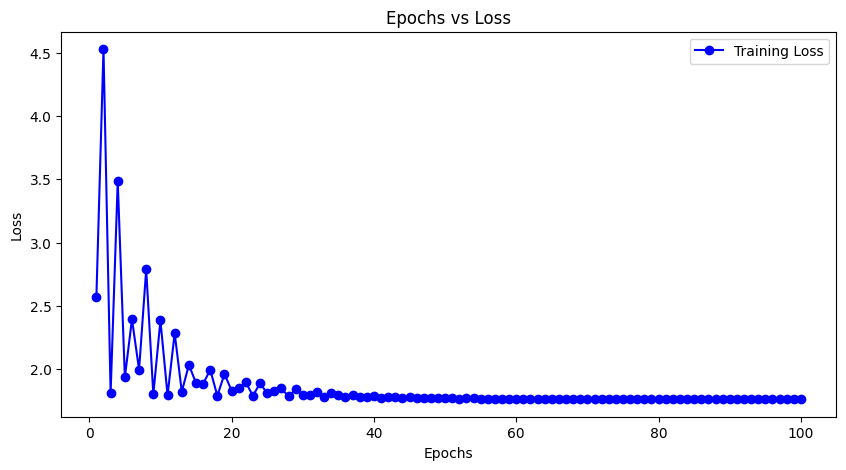

In [82]:
plot_loss_graph(loss_list)

In [ ]:
import torch
print(torch.cuda.is_available())

True


Although the MLP can overfit on the training dataset because of the high-dimensional input features,
it does not perform too well on the test set.
Let's see if we can beat this score with our graph networks:

In [ ]:
node_gnn_model, node_gnn_result = train_node_classifier(
    model_name="GNN", layer_name="GCN", dataset=graph_data, c_hidden=16, num_layers=2, dp_rate=0.1
)
print_results(node_gnn_result)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


RuntimeError: ignored